In [9]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [21]:
def load_data():
    data = pd.read_pickle('../../data/dataframes/data.pkl')
    nomination_onehot = pd.read_pickle('../../data/dataframes/nomination_onehot.pkl')
    selected_performers_onehot = pd.read_pickle('../../data/dataframes/selected_performers_onehot.pkl')
    selected_directors_onehot = pd.read_pickle('../../data/dataframes/selected_directors_onehot.pkl')
    selected_studio_onehot = pd.read_pickle('../../data/dataframes/selected_studio_onehot.pkl')
    selected_scriptwriter_onehot = pd.read_pickle('../../data/dataframes/selected_scriptwriter_onehot.pkl')
    review_dataframe = pd.read_pickle('../../data/dataframes/review_dataframe.pkl')
#     tf_idf = pd.read_pickle('../../data/dataframes/tfidf.pkl')
#     lda_topics = pd.read_pickle('../eigacom_review/topics.pkl')

    
    # selected_directors_onehotとselected_scriptwriter_onehotの重複した人
    duplicate_scriptwriter = set(selected_directors_onehot.columns) & set(selected_scriptwriter_onehot.columns)
    selected_scriptwriter_onehot = selected_scriptwriter_onehot.drop(duplicate_scriptwriter, axis=1)
    
    frames = [nomination_onehot,selected_performers_onehot,selected_directors_onehot,selected_studio_onehot,selected_scriptwriter_onehot,]

    df = data
    for f in frames:
        df = pd.merge(df, f, on='id')
    
    drop_elements = ["director", "other_nominates", "performers", "production_studio", "scriptwriter", "title",  'selected_performers', 'selected_directors', 'selected_studio',
       'selected_scriptwriter']
    df_drop = df.drop(drop_elements, axis=1)

    return df_drop, data

In [22]:
def standard(x_train, x_test):
    stdsc = StandardScaler()

    # 訓練用のデータを標準化
    x_train_std = stdsc.fit_transform(x_train)
    # 訓練用データを基準にテストデータも標準化
    x_test_std = stdsc.transform(x_test)
    
    return x_train_std, x_test_std

In [23]:
# 多重共線性の排除 (共分散0.7以上のfeatureを削除)

def collinearity(X):

    # 改善前
#     cor=np.corrcoef(X.T)
#     type(cor)
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(cor, vmin=0.70,vmax=1,cmap=plt.cm.Spectral_r)

    # 改善
    drop_clm = ['吉田一夫']
    X = X.drop(drop_clm,  axis=1)

    # 改善後
    
#     cor=np.corrcoef(X.T)
#     type(cor)
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(cor, vmin=0.80,vmax=1,cmap=plt.cm.Spectral_r)
    
    return X

In [24]:
def data_processing(test_year):
    df, data = load_data()
    
    df = collinearity(df)
    
    train = df.loc[df["year"] != test_year]
    test = df.loc[df["year"] == test_year]
    
    # 入力データの作成
    y_train = train['prize'].ravel()
    x_train = train.drop(['prize', 'year'], axis=1)
    
    features = x_train.columns
    
    x_train = x_train.values # 学習データ
    
    # テストデータの作成
    y_test = test['prize'].ravel()
    x_test = test.drop(['prize', 'year'], axis=1)
    x_test = x_test.values # テストデータ

    # データの標準化
    x_train_std, x_test_std = standard(x_train, x_test)
    
    return x_train_std, x_test_std, y_train, y_test, features

In [25]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [26]:
def main():
    
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all_lr = np.array([])
    probs_all_lda = np.array([])
    probs_all = np.array([])
    
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features = data_processing(y)
        y_true_all = np.hstack((y_true_all, y_test))
       
        # logistic regression
        lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001) # ロジスティック回帰モデルのインスタンスを作成
        lr.fit(x_train_std, y_train) # ロジスティック回帰モデルの重みを学習
        probs_lr = lr.predict_proba(x_test_std)
        probs_all_lr = np.hstack((probs_all_lr, probs_lr[:,1]))
        
        # LDA
        lda = LDA(solver="eigen", shrinkage=1).fit(x_train_std,  y_train)
        probs_lda = lda.predict_proba(x_test_std)
        probs_all_lda = np.hstack((probs_all_lda, probs_lda[:,1]))
        
        
        probs = (probs_lda[:,1] + probs_lr[:,1]) * 0.5
        probs_all = np.hstack((probs_all, probs))
        print(probs)

        # 混同行列
        y_pred = np.where((probs ==  max(probs)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    
    auc_lr = roc_auc_score(y_true_all, probs_all_lr)
    auc_lda = roc_auc_score(y_true_all, probs_all_lda)
    auc = roc_auc_score(y_true_all, probs_all)
    
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC all: ")
    print(auc)
    print("AUC LR: ")
    print(auc_lr)
    print("AUC LDA: ")
    print(auc_lda)
    print()
    return

[0.46361088 0.25180222 0.26733357 0.25302101 0.27045759]
[0.26543696 0.24998238 0.27031179 0.68469701 0.30292772]
[0.52087332 0.64533379 0.24878135 0.28385161 0.25182512]
[0.27973735 0.24883651 0.25974255 0.25002038 0.40859532]
[0.25816558 0.39874159 0.26258625 0.71200922 0.24970597]
[0.75497681 0.24888899 0.26616516 0.44822335 0.25261673]
[0.25328626 0.46211129 0.2462538  0.3170485  0.25761703]
[0.54422552 0.24631817 0.28048133 0.24679323 0.25107992]
[0.24678899 0.25527721 0.33539692 0.25142494 0.2493778 ]
[0.24795    0.25992119 0.43977499 0.24957295 0.25117732]
[0.75417919 0.24705315 0.24952552 0.25282045 0.25133815]
[0.25055162 0.25371623 0.28178785 0.50982372 0.25517117]
[0.73787942 0.27029364 0.25064624 0.2532289  0.25253002]
[0.70808851 0.47834605 0.25484785 0.248813   0.27654908]
[0.75155939 0.25995765 0.29554823 0.25400588 0.25172932]
[0.75762298 0.28376231 0.24821561 0.24982171 0.39387985]
[0.27706034 0.75673092 0.26270644 0.41802787 0.24783822]
[0.33988622 0.25531097 0.248914

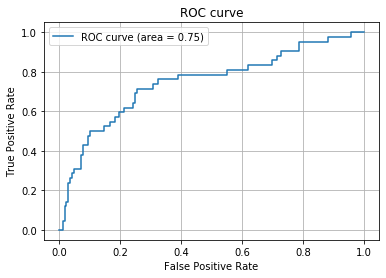

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC all: 
0.746407438715131
AUC LR: 
0.7503522118906735
AUC LDA: 
0.745280360664976



In [27]:
main()